In [204]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [205]:
sales_data = pd.read_csv('../Data/SalesData.csv')
sales_data.head()

,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London
2,1-11-2015,11,4,2015,1,Injection 1,Dermafiller,Pharmacy 2,Outside London M25
3,1-11-2015,11,4,2015,1,Injection 2,Dermafiller,Pharmacy 2,Outside London M25
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands"


In [206]:
columns_to_drop= ['Pharmacy', 'Product', 'Location']
sales_data.drop(columns=columns_to_drop, inplace=True)

In [207]:
sales_data.head()

,Date,Month,Quarter,Year,Qty,Category
0,1-11-2015,11,4,2015,2,Skinbooster
1,1-11-2015,11,4,2015,1,Skinbooster
2,1-11-2015,11,4,2015,1,Dermafiller
3,1-11-2015,11,4,2015,1,Dermafiller
4,1-11-2015,11,4,2015,4,Skinbooster


In [208]:
encoder = OneHotEncoder()
encoder.fit(sales_data[['Category']])

OneHotEncoder()

In [209]:
encoded_columns = encoder.transform(sales_data[['Category']]).toarray()

In [210]:
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['Category']))
df = pd.concat([sales_data, encoded_df], axis=1)
df.drop('Category', axis=1, inplace=True)

In [211]:
df

,Date,Month,Quarter,Year,Qty,Category_Dermafiller,Category_Mesotherapy,Category_Needles,Category_Profilho,Category_Skinbooster,Category_Skincare
0,1-11-2015,11,4,2015,2,0.0,0.0,0.0,0.0,1.0,0.0
1,1-11-2015,11,4,2015,1,0.0,0.0,0.0,0.0,1.0,0.0
2,1-11-2015,11,4,2015,1,1.0,0.0,0.0,0.0,0.0,0.0
3,1-11-2015,11,4,2015,1,1.0,0.0,0.0,0.0,0.0,0.0
4,1-11-2015,11,4,2015,4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
68631,1-3-2022,3,1,2022,2,0.0,0.0,0.0,0.0,0.0,1.0
68632,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0
68633,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0
68634,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0


In [212]:
df = df.groupby(['Date'],as_index=False)['Qty'].agg("sum")
print(df)

        Date    Qty
0   1-1-2016     76
1   1-1-2017    328
2   1-1-2018   2328
3   1-1-2019   4948
4   1-1-2020   6204
..       ...    ...
72  1-9-2017   1234
73  1-9-2018   4642
74  1-9-2019   6613
75  1-9-2020  10034
76  1-9-2021  12261

[77 rows x 2 columns]


In [213]:
df = df.rename(columns={'fecha': 'Date'})
df['Date'] = pd.to_datetime(df.Date, format="%d-%m-%Y")
df = df.set_index('Date')
#df = df.rename(columns={'x': 'y'})
#df = df.asfreq('MS')
df = df.sort_index()
df.head()

# df['Date'] = pd.to_datetime(df.Date, format="%d-%m-%Y")
# df = df.sort_values(by='Date')
# df = df.set_index(df.Date)
# df.drop('Date', axis = 1, inplace = True)
# print('Column datatypes= \n',df.dtypes)
# df

,Qty
Date,
2015-11-01,9
2015-12-01,35
2016-01-01,76
2016-02-01,59
2016-03-01,144


In [214]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [215]:
# # Verify that a temporary index is complete
# # ==============================================================================
# (df.index == pd.date_range(start=df.index.min(),
#                              end=df.index.max(),
#                              freq=df.index.freq)).all()

In [216]:
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)

Shape of the data=  (77, 1)
Column datatypes= 
 Qty    int64
dtype: object


Train dates : 2015-11-01 00:00:00 --- 2020-12-01 00:00:00  (n=62)
Test dates  : 2021-01-01 00:00:00 --- 2022-03-01 00:00:00  (n=15)


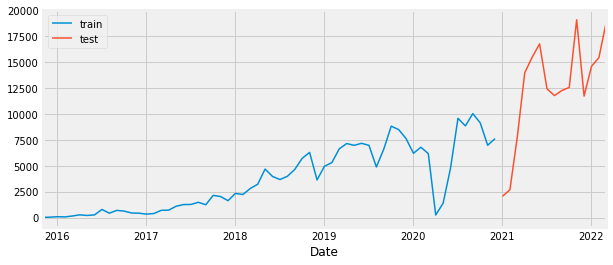

In [217]:
# Split data into train-test
# ==============================================================================
steps = 15
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Qty'].plot(ax=ax, label='train')
data_test['Qty'].plot(ax=ax, label='test')
ax.legend()

In [218]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['Qty'])
forecaster

c:\Users\galea\anaconda3\lib\site-packages\skforecast\utils\utils.py:522: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\skforecast\utils\utils.py:522: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 61] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-23 14:05:30 
Last fit date: 2023-03-23 14:05:30 
Skforecast version: 0.6.0 
Python version: 3.9.7 

In [219]:
# Predictions
# ==============================================================================
steps = 15
predictions = forecaster.predict(steps=steps)
predictions.head(5)

c:\Users\galea\anaconda3\lib\site-packages\skforecast\utils\utils.py:579: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


6     4694.93
7     2309.28
8     2708.77
9     3206.64
10    5495.51
Name: pred, dtype: float64

TypeError: index type not supported

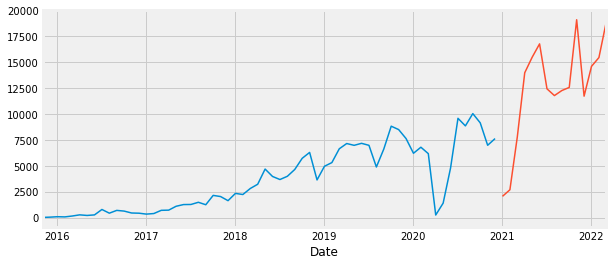

In [220]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Qty'].plot(ax=ax, label='train')
data_test['Qty'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()